## Let's build a TextCategorizer Model using spaCy

In [ ]:
import pandas as pd 
import spacy
from spacy.tokens import Doc, DocBin
import os

In [ ]:
RUN_IN_COLAB = 'google.colab' in str(get_ipython())

In [ ]:
if RUN_IN_COLAB:
  !python -m spacy download de_core_news_lg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 567.8 MB 21 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_lg')


In [ ]:
# TODO: Remove
def load_model(name): 
    nlp = spacy.load(name)
    de_stop_words = nlp.Defaults.stop_words
    return nlp, de_stop_words

!mkdir -p ./data/processed/raw/

In [ ]:
# Read training and dev datasets splits
BASE_PATH = os.path.join("./data/processed/raw")

def get_split(split, base_path=BASE_PATH): 
    return pd.read_csv(os.path.join(base_path, f"{split}.csv"))

In [ ]:
from src.models.helpers import load_model

In [ ]:
large_model = "de_core_news_lg"

nlp, stop_words = load_model(large_model)

In [ ]:
train_df = get_split(split="training")
train_df.head(3)

,text,tokens,tokens_norm,text_proc,cats,label
0,Wenn Ihnen eine angenehme Arbeitsatmosphäre mi...,"[Wenn, Ihnen, eine, angenehme, Arbeitsatmosphä...","['angenehm', 'arbeitsatmosphäre', 'enthusiasmu...",angenehm arbeitsatmosphäre enthusiasmus wert f...,"{'tech': False, 'soft': False, 'none': True}",none
1,***Abitur / Fachhochschulreife,"[*, *, *, Abitur, /, Fachhochschulreife]","['abitur', 'fachhochschulreife']",abitur fachhochschulreife,"{'tech': False, 'soft': False, 'none': True}",none
2,Routinierter Umgang mit MS Office-Anwendungen,"[Routinierter, Umgang, mit, MS, Office-Anwendu...","['routinierter', 'umgang', 'ms', 'office-anwen...",routinierter umgang ms office-anwendunge,"{'tech': True, 'soft': False, 'none': False}",tech


In [ ]:
dev_df = get_split(split="dev")
dev_df.head(3)

,text,tokens,tokens_norm,text_proc,cats,label
0,Assistenz der Geschäftsführung m/w,"[Assistenz, der, Geschäftsführung, m, /, w]","['assistenz', 'geschäftsführung', 'm', 'w']",assistenz geschäftsführung m w,"{'tech': False, 'soft': False, 'none': True}",none
1,Detaillierte Kenntnisse des Java Memory Models.,"[Detaillierte, Kenntnisse, des, Java, Memory, ...","['detaillierte', 'kenntnis', 'java', 'memory',...",detaillierte kenntnis java memory model,"{'tech': True, 'soft': False, 'none': False}",tech
2,Umzugsbereitschaft in Richtung Osnabrück (Wohn...,"[Umzugsbereitschaft, in, Richtung, Osnabrück, ...","['umzugsbereitschaft', 'richtung', 'osnabrück'...",umzugsbereitschaft richtung osnabrück wohnsitz...,"{'tech': False, 'soft': True, 'none': False}",soft


In [ ]:
test_df = get_split(split="test")
test_df.head(3)

,text,tokens,tokens_norm,text_proc,cats,label
0,Umfangreiche Kenntnisse mind. eines der CAD-Sy...,"[Umfangreiche, Kenntnisse, mind., eines, der, ...","['umfangreich', 'kenntnis', 'mind.', 'cad-syst...",umfangreich kenntnis mind. cad-system proe wf4...,"{'tech': True, 'soft': False, 'none': False}",tech
1,Anschreiben:,"[Anschreiben, :]",['anschreiben'],anschreiben,"{'tech': False, 'soft': False, 'none': True}",none
2,Sehr gute Kenntnisse der Office-Anwendungen.,"[Sehr, gute, Kenntnisse, der, Office-Anwendung...","['kenntnis', 'office-anwendunge']",kenntnis office-anwendunge,"{'tech': True, 'soft': False, 'none': False}",tech


## Build the Binary Docs for Training

For this particular model, I have used the raw text, as I want to use it as one of the baselines for training.

In [ ]:
# Let's process training data

def data_to_bindoc(df, split):
    docs = []
    for idx, doc in enumerate(nlp.pipe(df['text'], batch_size=100)):
        doc.cats = eval(df.iloc[idx].cats)
        docs.append(doc)
            
    doc_bin = DocBin(docs=docs)
    data_path = f"./data/{split}_raw.spacy"
    doc_bin.to_disk(data_path)
    print(f"Proccesed and saved BinDoc for split:{split} to:{data_path}")

In [ ]:
data_to_bindoc(train_df, "train")

Proccesed and saved BinDoc for split:train to:./data/train_raw.spacy


In [ ]:
data_to_bindoc(dev_df, "dev")

Proccesed and saved BinDoc for split:dev to:./data/dev_raw.spacy


In [ ]:
data_to_bindoc(test_df, "test")

Proccesed and saved BinDoc for split:test to:./data/test_raw.spacy


## Process the config

In [ ]:
!python -m spacy init fill-config ./config/base_config.cfg ./config/config.cfg

✔ Auto-filled config with all values
✔ Saved config
config/config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [ ]:
! python -m spacy debug data ./config/config.cfg


============================ Data file validation ============================
tcmalloc: large alloc 1200005120 bytes == 0x5de8c000 @  0x7f2246f8a2a4 0x7f22260aae09 0x7f22260a9cdf 0x7f22260a6675 0x7f22260a6e2e 0x4f750a 0x4997a2 0x55cd91 0x5d8941 0x49abe4 0x7f20a9fb5d78 0x7f20a9fb870e 0x7f20a9fc05a7 0x7f20a9fc3e85 0x5d8d8c 0x55dc1e 0x5d8868 0x4990ca 0x7f20a9fb5d78 0x7f20a9fb870e 0x7f20a9fbfe4b 0x5d80be 0x5d8d8c 0x55ea20 0x55d078 0x5d8941 0x49abe4 0x55d078 0x5d8941 0x4997a2 0x55d078
tcmalloc: large alloc 1213743104 bytes == 0xc932c000 @  0x7f2246f8a2a4 0x7f22260a83a2 0x7f22260a9cdf 0x7f22260a6675 0x7f22260a6e2e 0x4f750a 0x4997a2 0x55cd91 0x5d8941 0x49abe4 0x5d8868 0x4997c7 0x7f20a9fb5d78 0x7f20a9fb870e 0x7f20a9fbfe4b 0x5d80be 0x5d8d8c 0x55ea20 0x55d078 0x5d8941 0x49abe4 0x55d078 0x5d8941 0x4997a2 0x55d078 0x5d8941 0x49abe4 0x55cd91 0x5d8941 0x5d8416 0x55f797
✔ Pipeline can be initialized with data
✔ Corpus is loadable

=============================== Training stats =====================

## Perform Training

In [ ]:
!python -m spacy train ./config/config.cfg --gpu-id 0 --output textcat_simple

ℹ Saving to output directory: textcat_simple
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
[2022-12-22 19:41:32,497] [INFO] Set up nlp object from config
INFO:spacy:Set up nlp object from config
[2022-12-22 19:41:32,508] [INFO] Pipeline: ['tok2vec', 'textcat']
INFO:spacy:Pipeline: ['tok2vec', 'textcat']
[2022-12-22 19:41:32,512] [INFO] Created vocabulary
INFO:spacy:Created vocabulary
[2022-12-22 19:41:35,092] [INFO] Added vectors: de_core_news_lg
INFO:spacy:Added vectors: de_core_news_lg
tcmalloc: large alloc 1200005120 bytes == 0xa348a000 @  0x7ffb3abdd2a4 0x7ffb19d0ae09 0x7ffb19d09cdf 0x7ffb19d06675 0x7ffb19d06e2e 0x4f750a 0x4997a2 0x55cd91 0x5d8941 0x49abe4 0x7ff99dc39d78 0x7ff99dc3c70e 0x7ff99dc445a7 0x7ff99dc47e85 0x5d8d8c 0x55dc1e 0x5d8868 0x4990ca 0x7ff99dc39d78 0x7ff99dc3c70e 0x7ff99dc43e4b 0x5d80be 0x5d8d8c 0x55ea20 0x55d078 0x5d8941 0x49abe4 0x4fe253 0x49abe4 0x55d078 0x5d8941
tcmalloc: large alloc 1213743104 bytes == 0x7f854000

## Evaluate


Let's load the best model and try to evaluate on a single example

In [ ]:
!ls textcat_simple/

evaluate.json  model-best  model-last


In [ ]:
nlp = spacy.load("textcat_simple/model-best")

In [ ]:
doc = nlp("Kenntnisse im Bereich Online-Dienste von Vorteil")
doc.cats

{'tech': 0.9993124008178711,
 'soft': 0.0005922773852944374,
 'none': 9.535031131235883e-05}

### Evaluate using spacy evaluate

In [ ]:
!python -m spacy evaluate textcat_simple/model-best/ ./data/test_raw.spacy --output textcat_simple/evaluate.json

ℹ Using CPU
ℹ To switch to GPU 0, use the option: --gpu-id 0

================================== Results ==================================

TOK                 100.00
TEXTCAT (macro F)   93.65 
SPEED               2964  


=========================== Textcat F (per label) ===========================

           P       R       F
tech   95.36   87.27   91.14
soft   92.93   95.18   94.04
none   94.74   96.84   95.78


======================== Textcat ROC AUC (per label) ========================

       ROC AUC
tech      0.98
soft      0.99
none      0.99

✔ Saved results to textcat_simple/evaluate.json


In [ ]:
# Save best model
!tar -czvf best_model_raw.tar.gz textcat_simple/model-best/* textcat_simple/evaluate.json

textcat_simple/model-best/config.cfg
textcat_simple/model-best/meta.json
textcat_simple/model-best/textcat/
textcat_simple/model-best/textcat/cfg
textcat_simple/model-best/textcat/model
textcat_simple/model-best/tok2vec/
textcat_simple/model-best/tok2vec/cfg
textcat_simple/model-best/tok2vec/model
textcat_simple/model-best/tokenizer
textcat_simple/model-best/vocab/
textcat_simple/model-best/vocab/key2row
textcat_simple/model-best/vocab/strings.json
textcat_simple/model-best/vocab/lookups.bin
textcat_simple/model-best/vocab/vectors
textcat_simple/model-best/vocab/vectors.cfg
textcat_simple/evaluate.json


In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
save_to = "/content/drive/MyDrive/tb_challenge/"
!cp best_model_raw.tar.gz $save_to

## Obtain Predictions from Text Data

In [ ]:
best_model = "./textcat_simple/model-best/"
test_data = "./data/test_raw.spacy"

In [ ]:
nlp = spacy.load(best_model)
docs = DocBin().from_disk(test_data)

In [ ]:
def get_key(d, value):
  return next((k for k, v in d.items() if v == value), None) 

In [ ]:
idx_to_label = {0: "tech", 1: "soft", 2: "none"}
label_to_idx = {"tech": 0, "soft": 1, "none": 2}

In [ ]:
def get_preds_and_gold(nlp, docs):
  """
  Created this function to be able to create the confusion matrix
  """
  preds, gold = [], []
  for doc in docs.get_docs(nlp.vocab):
    true_label = get_key(doc.cats, True)
    doc = nlp(doc.text )
    pred_label = max(doc.cats, key=doc.cats.get)
    preds.append(label_to_idx[pred_label])
    gold.append(label_to_idx[true_label])
  return preds, gold 

In [ ]:
preds, gold = get_preds_and_gold(nlp, docs)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
gold_arr, pred_arr = np.array(gold), np.array(preds)
gold_arr.shape, pred_arr.shape

((1502,), (1502,))

In [ ]:
def plot_matrix(y_preds, gold, labels): 
  c_matrix = confusion_matrix(y_true=gold, y_pred=y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(8,8))
  display_matrix = ConfusionMatrixDisplay(confusion_matrix=c_matrix,
                                          display_labels=labels)
  display_matrix.plot(cmap="RdPu",values_format=".2f", ax=ax, colorbar=False)
  plt.title("Confusion Matrix for spaCy model - Cleaned data")
  plt.show()

In [ ]:
classes = ["soft","tech","none"]

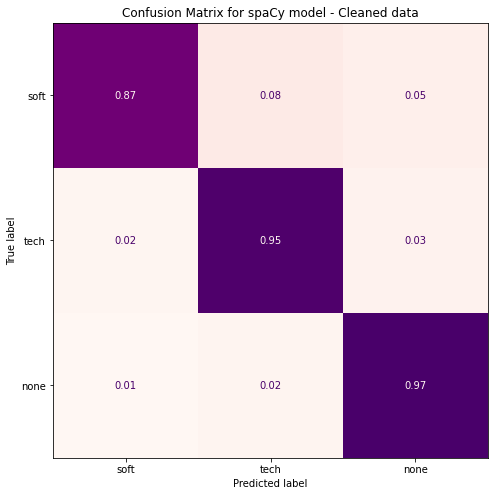

In [ ]:
plot_matrix(pred_arr, gold_arr, classes)